# 6. Multiclass Classification Modeling - Rural

<a id='sections'></a>
**Sections**

- [**Multiclass Classification Modeling - Rural**](#multiclass-classification-modeling-rural)
    - [6.1. Data Preprocessing](#data-preprocessing)
        - (1) Import Data Files
        - (2) Convert Feature Types
        - (3) Mask Multi-Class Label
    - [6.2. Customize Score](#customize-score)
        - (1) Class-Weighted-f2score
        - (2) Weighted-Confusion_matrix-Score
        - (3) Check the Default Model
    - [6.3. Model Tuning](#model-tuning)
    - [6.4. Oversamling](#oversamling)
    - [6.5. Examine the Selected Model](#examine-the-selected-model)
        - (1) Model Performance
        - (2) Feature Importance
        - (3) Save the Model
        - (4) Visualize by Map
    - [6.6. Binary + Multiclass Model](#binary-multiclass-model)
        - (1) Examine the Performance on Testing Data
        - (2) Apply the Model for Future Prediction

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import pickle
from numpy import argmax
import importlib
import collections
import time
import getpass
import datetime as datetime
from shapely import wkt
from matplotlib import pyplot as plt

import categorical_embedder as ce
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  LabelEncoder
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, brier_score_loss, auc
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, make_scorer, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn import metrics
from xgboost import XGBClassifier

Using TensorFlow backend.
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xl43843\Anaconda3\en

In [2]:
# import modules
import sys; sys.path.insert(0, '..')
import src.multiclass_models
# importlib.reload (src.multiclass_models)
from src.multiclass_models import *

# 6.1. Data Processing

[[back to top](#sections)]
<a id='data-preprocessing'></a>

## (1) Import Data Files

In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
with open(base_file_dir+'data/processed/df_rural_train_2014_2017.pkl', 'rb') as f:
    df_rural_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_train_label_2014_2017.pkl', 'rb') as f:
    df_rural_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_2018.pkl', 'rb') as f:
    df_rural_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_label_2018.pkl', 'rb') as f:
    df_rural_test_label = pickle.load(f)

In [5]:
print(df_rural_train.shape)
print(df_rural_train_label.shape)
print(df_rural_test.shape)
print(df_rural_test_label.shape)

(22736, 62)
(22736,)
(5684, 62)
(5684,)


## (2) Convert Feature Types

In [6]:
# convert PC into a ordinal numeric field
df_rural_train=func_PC_numeric(df_rural_train)
df_rural_test=func_PC_numeric(df_rural_test)

# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_rural_train.columns) if i not in remove_list]
df_rural_train_sub = df_rural_train[targetlist]
df_rural_test_sub = df_rural_test[targetlist]


## (3) Mask Multi-class Label

<mark> Different multi-class scenarios have been studied in this study </mark> 
- Plan A:
Classify cases of 0 crash, 1 crash, 2 crashes, >=3 crashes
- Plan B:
Classify cases of 0 crash, 1 Or 2 crashes, >=3 crashes
- Plan C:
Classify cases of 0 crash, 1 crash, >= 2 crashes

In [7]:
print(collections.Counter(df_rural_train_label))
print(collections.Counter(df_rural_test_label))

# # Plan A
# df_rural_train_cat_label=df_rural_train_label.mask(df_rural_train_label >= 3, 3)
# df_rural_test_cat_label=df_rural_test_label.mask(df_rural_test_label >= 3, 3)

# # Plan B
# df_rural_train_cat_label=df_rural_train_label.mask(df_rural_train_label==2, 1)
# df_rural_train_cat_label=y_train_cat_label.mask(df_rural_train_cat_label >= 3, 2)
# df_rural_test_cat_label=df_rural_test_label.mask(df_rural_test_label==2, 1)
# df_rural_test_cat_label=y_test_cat_label.mask(df_rural_test_cat_label >= 3, 2)

# Plan C
df_rural_train_cat_label=df_rural_train_label.mask(df_rural_train_label >= 3, 2)
df_rural_test_cat_label=df_rural_test_label.mask(df_rural_test_label >= 3, 2)

print(collections.Counter(df_rural_train_cat_label))
print(collections.Counter(df_rural_test_cat_label))

Counter({0.0: 21045, 1.0: 1273, 2.0: 239, 3.0: 69, 4.0: 33, 5.0: 23, 6.0: 15, 8.0: 9, 7.0: 7, 9.0: 5, 12.0: 5, 14.0: 4, 10.0: 3, 11.0: 2, 18.0: 1, 15.0: 1, 16.0: 1, 13.0: 1})
Counter({0.0: 5273, 1.0: 313, 2.0: 45, 3.0: 26, 4.0: 9, 7.0: 4, 5.0: 3, 8.0: 3, 9.0: 2, 10.0: 1, 17.0: 1, 6.0: 1, 21.0: 1, 15.0: 1, 11.0: 1})
Counter({0.0: 21045, 1.0: 1273, 2.0: 418})
Counter({0.0: 5273, 1.0: 313, 2.0: 98})


In [8]:
X_train = df_rural_train_sub
y_train = df_rural_train_cat_label
X_test = df_rural_test_sub
y_test = df_rural_test_cat_label

X_train_OHtransformed=func_OHtransform_var(X_train)
OHfname = func_OHtransformed_var(X_train)
X_test_OHtransformed=func_OHtransform_var(X_test)

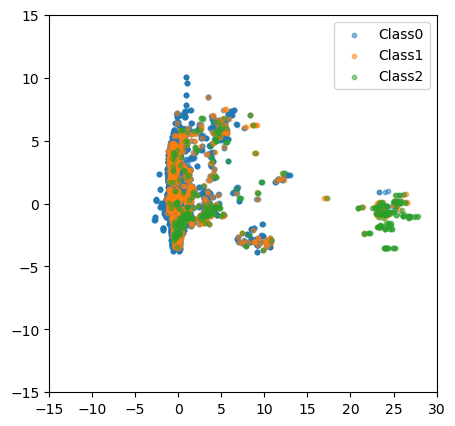

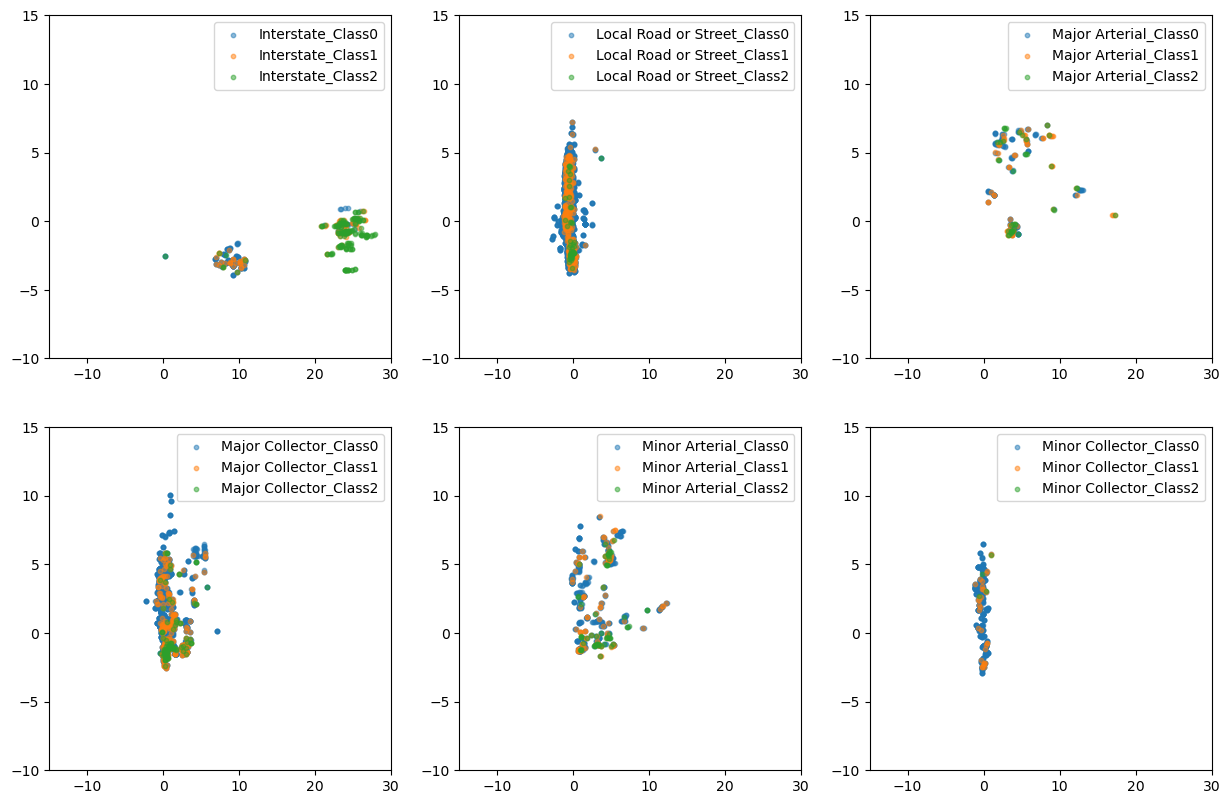

In [9]:
# Distribution of each roadway functional class in reduced dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed)
fig,ax=plt.subplots(figsize=(5,5),dpi=100)
for Class in [0,1,2]:
    df_X = X_train_OHtransformed_pca[df_rural_train_cat_label==Class]
    plt.scatter(df_X[:,0],df_X[:,1],label='Class'+str(Class),s=10,alpha=0.5)
plt.xlim((-15,30))
plt.ylim((-15,15))
plt.legend()

# Plot by roadway functional class
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=100)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_rural_train_sub['functional_classification']==rdclass]
    df_y = df_rural_train_cat_label[df_rural_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_Class0',s=10,alpha=0.5)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_Class1',s=10,alpha=0.5)
    ax[place_dict[rdclass]].scatter(df_X[df_y==2][:,0],df_X[df_y==2][:,1],label=rdclass+'_Class2',s=10,alpha=0.5)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

# 6.2. Customize Score

[[back to top](#sections)]
<a id='customize-score'></a>

<mark>**Goal setting**: </mark>
- <font color='purple'>The purpose of the multiclass model is to find out segments that have high crash risks (Class2), which have >=2 crashes. The model is designed to capture as many Class2 roads as possible.</font>
- <font color='purple'>The primary goal is to capture segments of high risks, the second goal is to identify segments that might have crashes (Class1), the last goal is to minimize the false alarm rate.</font>

To achieve the goal, two evaluation scores are designed:
- (1) class-weighted-f2score
- (2) weighted-confusion_matrix-score

## (1) Class-weighted-f2score

In [10]:
# # Plan A
# class_weight = {'No Crash':0.1,'1 Crash':0.2,'2 Crashes':0.3, '>=3 Crashes':0.4}
# # Plan B
# class_weight = {'No Crash':0.2,'1 OR 2 Crashes':0.3,'>=3 Crashes':0.5}
# Plan C
class_weight = {'No Crash':0.2,'1 Crash':0.3,'>=2 Crashes':0.5}
target_names = list(class_weight.keys())

## (2) Weighted-Confusion_matrix-Score

When predicting(classifying) the roadway risk level in the real world, the costs of different misclassification cases are different and the benefits of correctly classifying different classes should be valued differently. For example, predicting(classifying) true Class2 as Class1 is much more dangerous than predicting true Class1 as Class0, predicting(classifying) true Class0 as Class2 is much more troublesome than predicting true Class0 as Class1, correctly identifying Class2 is more valuable than correctly identifying Class0 in the context of roadway risk assessment. To address this need, a **scoring matrix** is designed to evaluate correct classifications and misclassifications of different scenarios. 

In the scoring matrix, a negative value is assigned to each misclassification cell and a positive value is assigned to each correct classification cell. In other words, the "win(s)" of the model is measured by multiplying the correct classification cells with positive values in the scoring matrix, the "loss(es)" of the model is measured by multiplying the misclassification cells with negative values in the scoring matrix. The more dangerous/troublesome the misclassification case is, a smaller negative value (higher absolute value) is assigned. The more valuable the correct classification case is, a higher positive value is assigned. 

To evaluate all the models at the same scale, the **weighted_confusion_matrix_score**, which is between [-2,1], is developed. The weighted_confusion_matrix_score is calculated by dividing the total points earned by the model by the highest number of total points a model could earn (classifying all the classes correctly). 


**scoring matrix**:

|             | Predict Class0 | Predict Class1 | Predict Class2 |
| ----------- | ----------- | ----------- |----------- |
| True Class0 | +1           | -1          |-2       |
| True Class1 | -4          | +2           |-3       |
| True Class2 | -6          | -5          |+3       |

For example: 

In a dataset, Class0 has 124 samples, Class1 has 33 samples, Class2 has 14 samples.

The best performance the model could achieve is:

|             | Predict Class0 | Predict Class1 | Predict Class2 |
| ----------- | ----------- | ----------- |----------- |
| True Class0 | 124         | 0          |0    |
| True Class1 | 0           | 33         | 0     |
| True Class2 | 0           | 0          |14      |

The highest number of points a model could earn, which is the denominator, is: 124 * 1 + 33 * 2 + 14 * 3 = 232

The worst performance of a model could achieve is 124 * (-2) + 33 * (-4) + 14 * (-6) = -464

Thus, the worst weighted_confusion_matrix_score a model could have is -464/232=-2

Now, let's suppose a model get the following confusion_matrix:

|             | Predict Class0 | Predict Class1 | Predict Class2 |
| ----------- | ----------- | ----------- |----------- |
| True Class0 | 100         | 4          |20     |
| True Class1 | 1           | 20         |12      |
| True Class2 | 2           | 4         |8      |

The total points earned by the model is calculated as: 

100 * 1 + 4 * (-1) + 20 * (-2) + 1 * (-4) + 20 * 2 + 12 * (-3) + 2 * (-6) + 4 * (-5) + 8 * 3 = 48

=> The weighted confusion_matrix_score of this model is 48/232 = 0.207


In [11]:
scoring_matrix = np.array([[1,-1,-2],[-3,2,-4],[-6,-5,3]])

<mark>Model evaluation</mark>
- Step 1: Select the top 5 models with highest class-weighted f2score
- Step 2: Select the model with highest weighted confusion_matrix_score among the top 5 models.

## (3) Check the Default Model

In [12]:
sampling = None

XGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax')

XGBmodel_pipeline = func_OH_classfication_pipeline (func_OHtransform_var, XGBmodel, sampling)
XGBmodel_pipeline_fitted = XGBmodel_pipeline.fit(X_train, y_train)
y_pred = XGBmodel_pipeline_fitted.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[Pipeline]  (step 1 of 3) Processing variable_transformer, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   9.3s
[[5212   41   20]
 [ 273   27   13]
 [  36   18   44]]
0.668496689811077


precision  recall  f1-score  f2-score
No Crash          0.944   0.988     0.966     0.979
1 Crash           0.314   0.086     0.135     0.101
>=2 Crashes       0.571   0.449     0.503     0.469
micro avg         0.929   0.929     0.929     0.929
macro avg         0.610   0.508     0.535     0.516
weighted avg      0.569   0.448     0.485     0.461

# 6.3. Model Tuning
[[back to top](#sections)]
<a id='model-tuning'></a>

In [13]:
with open(base_file_dir+'data/AWS Tuning results/Multiclass/Multiclass_Rural_XGB_search_results_round2.pkl', 'rb') as f:
    Multiclass_Rural_XGB_search_results = pickle.load(f)

In [14]:
cols_to_show = ['n_estimators','max_depth','eta','subsample','min_child_weight','wgt_f2score','wgt_cfm_score']
Multiclass_Rural_XGB_search_results[cols_to_show].sort_values(by=['wgt_f2score'],ascending=False).head(10)

n_estimators  max_depth  eta  subsample  min_child_weight  wgt_f2score  \
508             50          8  0.1        1.0                 9        0.506   
1018           100          7  0.1        1.0                 9        0.505   
417             50          7  0.1        1.0                 7        0.503   
2219           200          7  0.1        1.0                11        0.502   
3419           300          7  0.1        1.0                11        0.502   
4019           350          7  0.1        1.0                11        0.502   
4619           400          7  0.1        1.0                11        0.502   
2819           250          7  0.1        1.0                11        0.502   
1108           100          8  0.1        1.0                 9        0.502   
1118           100          8  0.1        1.0                 9        0.501   

      wgt_cfm_score  
508        0.641692  
1018       0.640723  
417        0.641208  
2219       0.640723  
3419       0.640723  
4019       0.640723  
4619       0.640723  
2819       0.640723  
1108       0.640562  
1118       0.640723

In [15]:
Multiclass_Rural_XGB_search_results[cols_to_show].sort_values(by=['wgt_cfm_score'],ascending=False).head(10)

n_estimators  max_depth  eta  subsample  min_child_weight  wgt_f2score  \
508             50          8  0.1        1.0                 9        0.506   
417             50          7  0.1        1.0                 7        0.503   
4253           400          3  0.3        0.8                 9        0.500   
3419           300          7  0.1        1.0                11        0.502   
2819           250          7  0.1        1.0                11        0.502   
4619           400          7  0.1        1.0                11        0.502   
4019           350          7  0.1        1.0                11        0.502   
1018           100          7  0.1        1.0                 9        0.505   
2219           200          7  0.1        1.0                11        0.502   
1118           100          8  0.1        1.0                 9        0.501   

      wgt_cfm_score  
508        0.641692  
417        0.641208  
4253       0.640885  
3419       0.640723  
2819       0.640723  
4619       0.640723  
4019       0.640723  
1018       0.640723  
2219       0.640723  
1118       0.640723

<mark>Finding: </mark>

The model with highest weighted confusion_matrix_score is the same as the model found by highest weighted f2score.

In [16]:
Best_wgt_f2score_models = Multiclass_Rural_XGB_search_results.sort_values(by=['wgt_f2score'],ascending=False).head(5)
Best_wgt_f2score_models.sort_values(by=['wgt_cfm_score'],ascending=False).head(5)

n_estimators  max_depth  eta  gamma  subsample  min_child_weight  \
508             50          8  0.1      7        1.0                 9   
417             50          7  0.1      7        1.0                 7   
1018           100          7  0.1      7        1.0                 9   
2219           200          7  0.1      7        1.0                11   
3419           300          7  0.1      7        1.0                11   

      wgt_precision  wgt_recall  wgt_f2score  NoCrash_precision  \
508           0.694       0.492        0.506              0.942   
417           0.694       0.489        0.503              0.942   
1018          0.671       0.492        0.505              0.942   
2219          0.663       0.488        0.502              0.942   
3419          0.663       0.488        0.502              0.942   

      NoCrash_recall  NoCrash_f2score  OneCrash_precision  OneCrash_recall  \
508            0.995            0.984               0.500            0.058   
417            0.996            0.985               0.500            0.048   
1018           0.994            0.983               0.439            0.058   
2219           0.994            0.983               0.435            0.064   
3419           0.994            0.983               0.435            0.064   

      OneCrash_f2score  TwoPlusCrash_precision  TwoPlusCrash_recall  \
508              0.070                   0.711                0.551   
417              0.059                   0.711                0.551   
1018             0.070                   0.701                0.551   
2219             0.077                   0.688                0.541   
3419             0.077                   0.688                0.541   

      TwoPlusCrash_f2score  wgt_cfm_score      time  
508                  0.577       0.641692  1.395772  
417                  0.577       0.641208  1.226929  
1018                 0.576       0.640723  2.242370  
2219                 0.565       0.640723  4.211313  
3419                 0.565       0.640723  6.139013

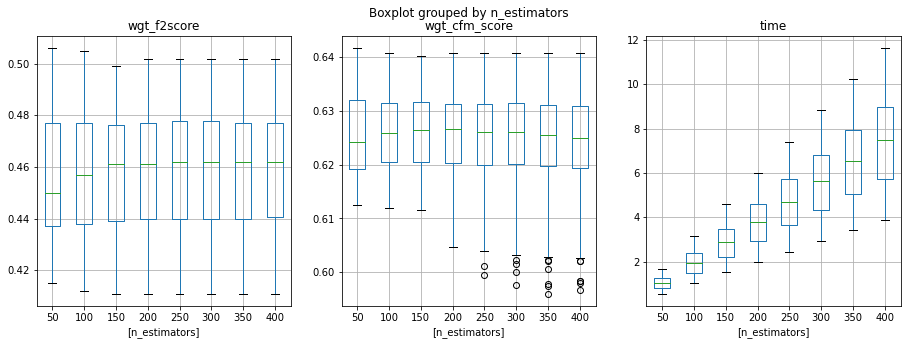

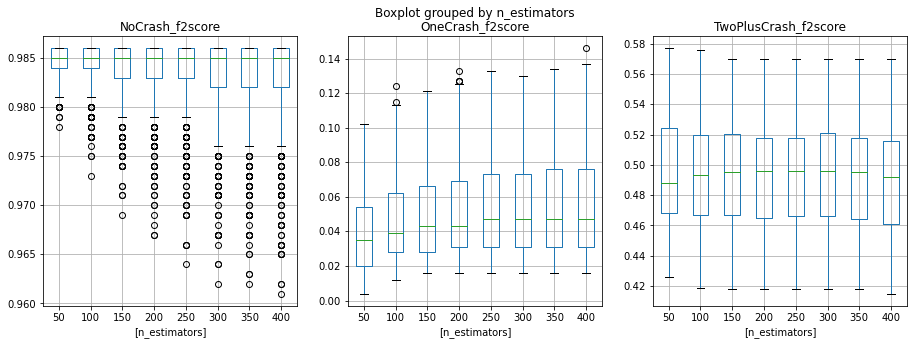

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
Multiclass_Rural_XGB_search_results.boxplot(column=['wgt_f2score'],by=['n_estimators'],ax=ax[0])
Multiclass_Rural_XGB_search_results.boxplot(column=['wgt_cfm_score'],by=['n_estimators'],ax=ax[1])
Multiclass_Rural_XGB_search_results.boxplot(column=['time'],by=['n_estimators'],ax=ax[2])
fig,ax = plt.subplots(1,3,figsize=(15,5))
Multiclass_Rural_XGB_search_results.boxplot(column=['NoCrash_f2score'],by=['n_estimators'],ax=ax[0])
Multiclass_Rural_XGB_search_results.boxplot(column=['OneCrash_f2score'],by=['n_estimators'],ax=ax[1])
Multiclass_Rural_XGB_search_results.boxplot(column=['TwoPlusCrash_f2score'],by=['n_estimators'],ax=ax[2])

<mark>Analysis</mark>
- Number of n_estimators
    - From n_estimators=50 to n_estimators=150, the more estimators applied, the higher wgt_f2score median is and the higher wgt_cfm_score median is. This means that from n_estimators=50 to n_estimators=150, in general, a higher wgt_f2score and a higher wgt_cfm_score could be achieved if more n_estimators are applied.
    - From n_estimators=150 to n_estimators=400, the wgt_f2score and the wgt_cfm_score are not improved whereas the time needed for model training increases a lot. 
- No matter how many n_estimators are applied, 'NoCrash' class has a very high f2score, 'OneCrash' class has an extremely low f2score, 'TwoPlusCrashes' class a moderate f2score.

**Conclusion** 

The number of tress should be less than 150 (n_estimators <= 150)

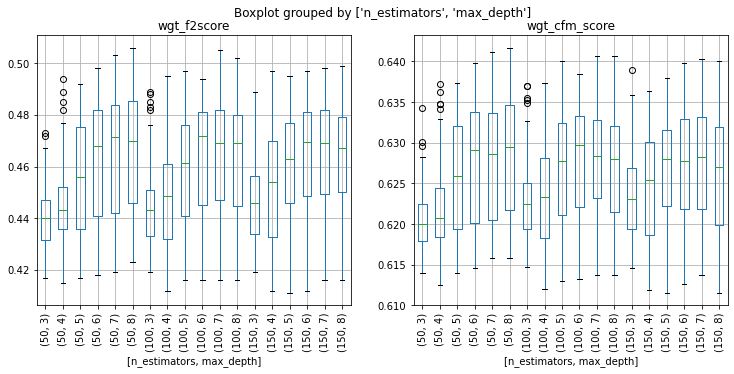

In [18]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
Multiclass_Rural_XGB_search_results[Multiclass_Rural_XGB_search_results['n_estimators']<=150]. \
boxplot(column=['wgt_f2score'],by=['n_estimators','max_depth'],ax=ax[0])
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), Rotation= 90) 
Multiclass_Rural_XGB_search_results[Multiclass_Rural_XGB_search_results['n_estimators']<=150]. \
boxplot(column=['wgt_cfm_score'],by=['n_estimators','max_depth'],ax=ax[1])
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), Rotation= 90) 

In [19]:
sampling=None
MulticlassXGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax',
    n_estimators=50,max_depth=8,eta=0.1,
    min_child_weight=9,subsample=1)

MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed, y_train)
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[[5247   11   15]
 [ 288   18    7]
 [  37    7   54]]
0.6870660423058291


precision  recall  f1-score  f2-score
No Crash          0.942   0.995     0.968     0.984
1 Crash           0.500   0.058     0.103     0.070
>=2 Crashes       0.711   0.551     0.621     0.577
micro avg         0.936   0.936     0.936     0.936
macro avg         0.717   0.535     0.564     0.544
weighted avg      0.694   0.492     0.535     0.506

# 6.4. Oversamling

[[back to top](#sections)]
<a id='oversamling'></a>

Oversampling Class 1 and Class 2

In [20]:
# np.random.seed(42)

# for Class1_addratio in [0,0.5,0.75,1]:
#     for Class2_addratio in [0,0.5,0.75,1]:

#         print(Class1_addratio,Class2_addratio)
#         Class1_index_to_dup = sorted(np.random.choice(X_train[y_train==1].index,
#                             size=int(y_train.value_counts()[1]*Class1_addratio), replace=False))
#         Class1_id_to_dup = np.where(X_train.index.isin(Class1_index_to_dup))[0]

#         Class2_index_to_dup = sorted(np.random.choice(X_train[y_train==2].index,
#                             size=int(y_train.value_counts()[2]*Class2_addratio), replace=False))
#         Class2_id_to_dup = np.where(X_train.index.isin(Class2_index_to_dup))[0]

#         X_train_OHtransformed_Oversampled = np.concatenate((X_train_OHtransformed,X_train_OHtransformed[Class1_id_to_dup,:],X_train_OHtransformed[Class2_id_to_dup,:]),axis=0)
#         y_train_Oversampled = np.concatenate((y_train.values,y_train.values[Class1_id_to_dup],y_train.values[Class2_id_to_dup]),axis=0)

#         MulticlassXGBmodel = XGBClassifier(
#             n_jobs=-1,random_state=42,
#             objective='multi:softmax',
#             n_estimators=50,max_depth=8,eta=0.1,
#             min_child_weight=9,gamma=0)

#         MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed_Oversampled, y_train_Oversampled)
#         y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
#         print(metrics.confusion_matrix(y_test, y_pred))
#         score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),np.array([[1,-1,-2],[-3,2,-4],[-6,-5,3]])))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
#         print(score)


<mark>Conclusion: </mark>
- Model trained without oversampled data achieved better performance

# 6.5. Examine the Selected Model

[[back to top](#sections)]
<a id='examine-the-selected-model'></a>

## (1) Model Performance

In [21]:
sampling=None
MulticlassXGBmodel = XGBClassifier(
    n_jobs=-1,random_state=42,
    objective='multi:softmax',
    n_estimators=50,max_depth=8,eta=0.1,
    min_child_weight=9,subsample=1)

MulticlassXGBmodel_fitted = MulticlassXGBmodel.fit(X_train_OHtransformed, y_train)
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)
print(metrics.confusion_matrix(y_test, y_pred))
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(y_test, y_pred),scoring_matrix))/np.sum(np.multiply(y_test.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(y_test, y_pred,class_weight)

[[5247   11   15]
 [ 288   18    7]
 [  37    7   54]]
0.6870660423058291


precision  recall  f1-score  f2-score
No Crash          0.942   0.995     0.968     0.984
1 Crash           0.500   0.058     0.103     0.070
>=2 Crashes       0.711   0.551     0.621     0.577
micro avg         0.936   0.936     0.936     0.936
macro avg         0.717   0.535     0.564     0.544
weighted avg      0.694   0.492     0.535     0.506

## (2) Feature Importance

Text(0.5, 1.0, 'Feature imprtance by weight \nthe number of times a feature is used to split the data across all trees')

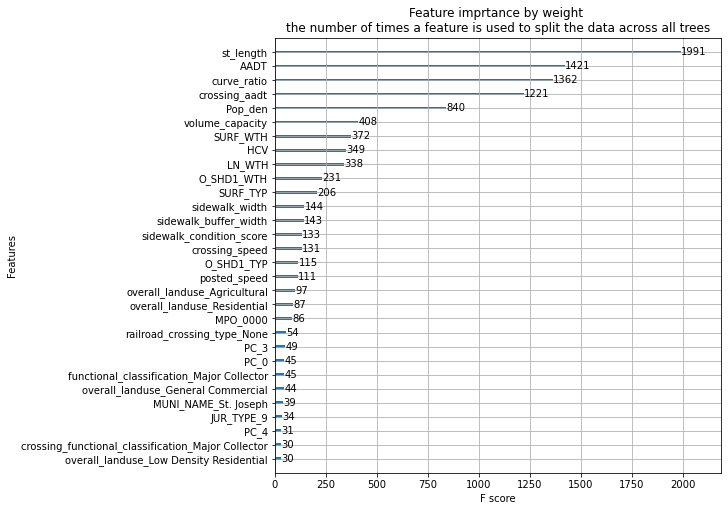

In [22]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (8, 8)

mapper = {'f{0}'.format(i): v for i, v in enumerate(OHfname)}
mapped = {mapper[k]: v for k, v in MulticlassXGBmodel_fitted.get_booster().get_score().items()}
#‘weight’: the number of times a feature is used to split the data across all trees.
plot_importance(mapped,max_num_features=30, importance_type='weight') # default
plt.title('Feature imprtance by weight \n'+'the number of times a feature is used to split the data across all trees')

## (3) Save the Model

In [23]:
# # Save model in pkl
# model_str = 'XGB'
# timestr=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_name = model_str+str(timestr)
# segment_intersection='segment'
# model_geography='rural'
# model_type='multiclass'
# print(model_name)
# path=base_file_dir+'models/'+segment_intersection+'/'+model_geography+'/'+model_type+'/'
# os.makedirs(path, exist_ok=True)
# with open(path+model_name+'.pkl', 'wb') as f:
#     pickle.dump(MulticlassXGBmodel_fitted, f)    

<mark>**XGB20210519-234920** renamed as **rural_multiclass_XGB_trainedw2014_2017**</mark>

## (4) Visualize by Map

### (a) Training Data

#### Observed Map

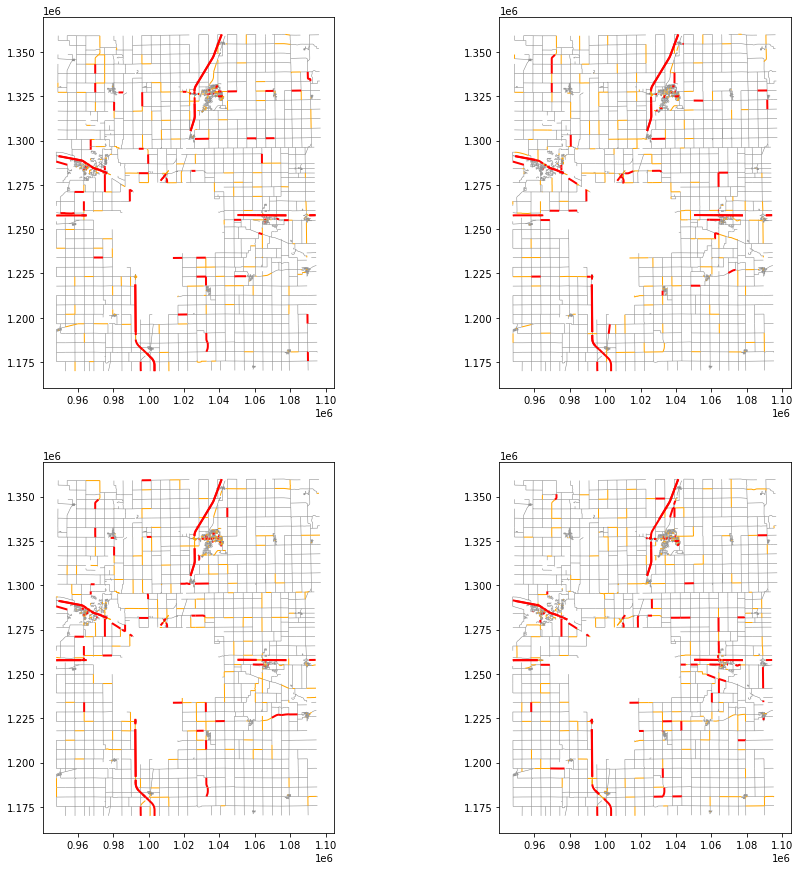

In [24]:
# Prepare plotting data
segment_intersection='segment'
model_geography='rural'

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()
plt_observed_crashes_map (axes[0],df_rural_train, df_rural_train_cat_label, 2014)
plt_observed_crashes_map (axes[1],df_rural_train, df_rural_train_cat_label, 2015)
plt_observed_crashes_map (axes[2],df_rural_train, df_rural_train_cat_label, 2016)
plt_observed_crashes_map (axes[3],df_rural_train, df_rural_train_cat_label, 2017)

plt.show()

#### Prediction Map

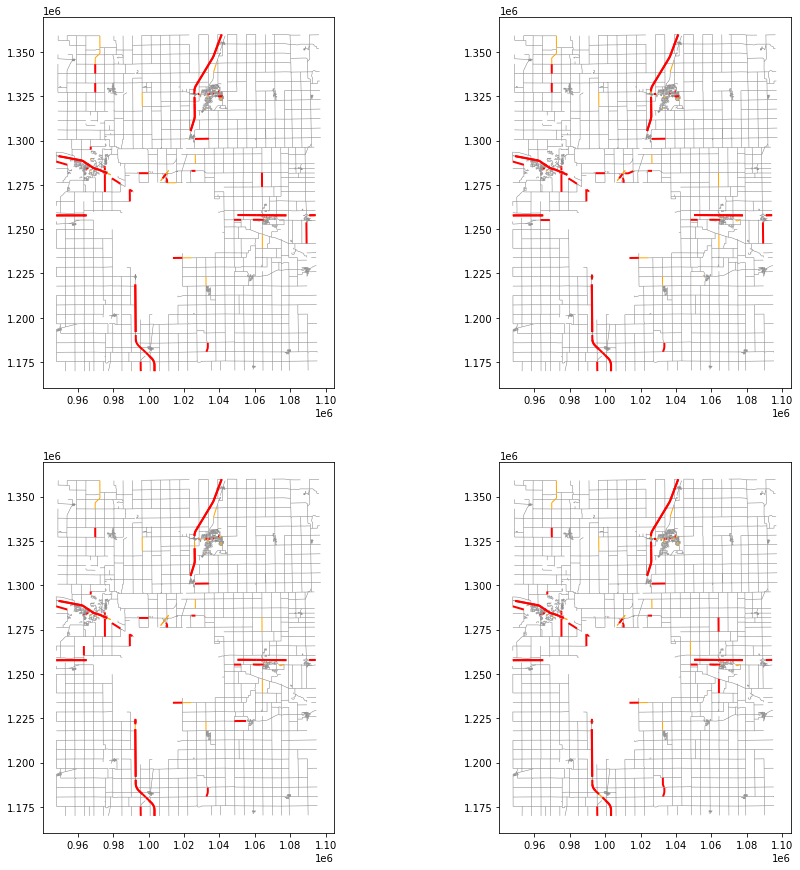

In [25]:
# Predicted values
y_pred = MulticlassXGBmodel_fitted.predict(X_train_OHtransformed)

segment_intersection='segment'
model_geography='rural'

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()

plt_prediction_maps (axes[0],df_rural_train, y_pred, 2014, segment_intersection, model_geography, 'XGB-MultiClass', 'prediction')
plt_prediction_maps (axes[1],df_rural_train, y_pred, 2015, segment_intersection, model_geography, 'XGB-MultiClass', 'prediction')
plt_prediction_maps (axes[2],df_rural_train, y_pred, 2016, segment_intersection, model_geography, 'XGB-MultiClass', 'prediction')
plt_prediction_maps (axes[3],df_rural_train, y_pred, 2017, segment_intersection, model_geography, 'XGB-MultiClass', 'prediction')

plt.show()

### (b) Testing Data

#### Observed Map

Text(0.5, 1.0, 'rural_XGB-MultiClass_observed')

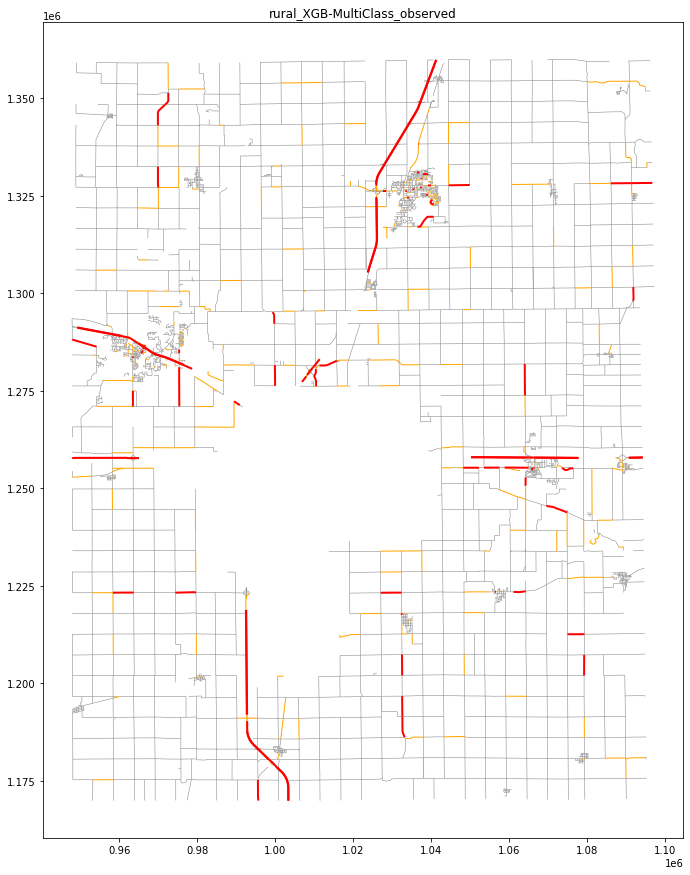

In [26]:
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_observed'
fig, axes = plt.subplots(figsize=(15,15))
plt_observed_crashes_map (axes,df_rural_test,df_rural_test_cat_label,2018)
plt.title(map_name)

#### Predicted Map

Text(0.5, 1.0, 'rural_XGB-MultiClass_prediction')

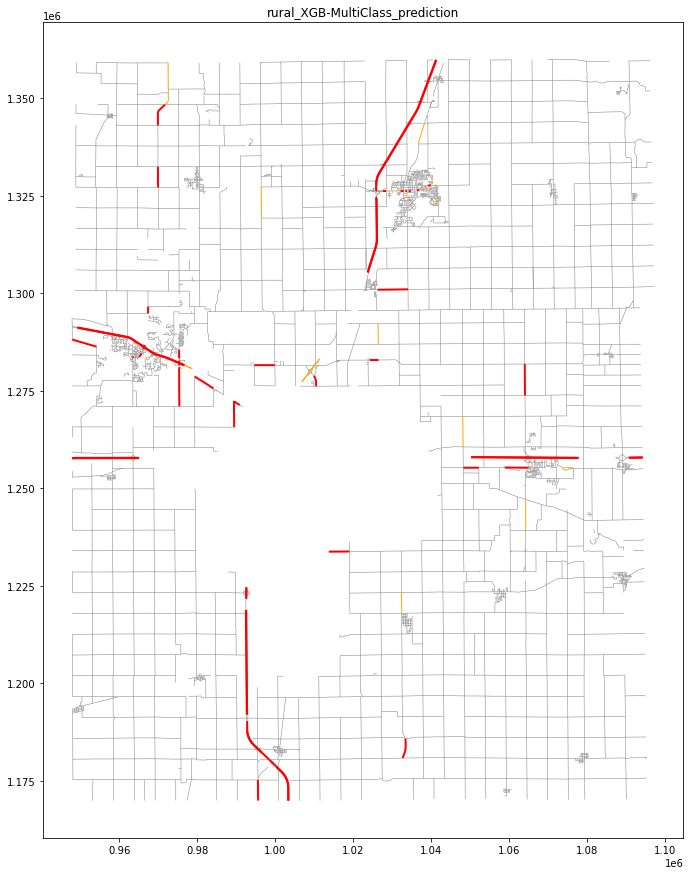

In [27]:
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_prediction'

# Predicted values
y_pred = MulticlassXGBmodel_fitted.predict(X_test_OHtransformed)

fig, axes = plt.subplots(figsize=(15,15))
plt_prediction_maps (axes, df_rural_test, y_pred, 2018, segment_intersection, model_geography, model_name, map_name)
plt.title(map_name)

# 6.6. Binary + Multiclass Model

[[back to top](#sections)]
<a id='binary-multiclass-model'></a>

Reviewing the results of the binary model and the results of the multiclass model together can help 
- (i) decrease the chances of missing roadways that are of high risk 
- (ii) identify roadways that of high risk from the ones that are identified as "risky roads" by the binary model.

## (1) Examine the Performance on Testing Data

In [12]:
model_name = 'rural_binary_XGB_trainedw2014_2017_best_thres0.378.pkl'
with open(base_file_dir+'/models/segment/rural/binary/'+ model_name, 'rb') as f:
    rural_binary_xgb = pickle.load(f)
    
model_name = 'rural_multiclass_XGB_trainedw2014_2017.pkl'
with open(base_file_dir+'/models/segment/rural/multiclass/'+ model_name, 'rb') as f:
    rural_multiclass_xgb = pickle.load(f)    
    

In [13]:
# Binary model prediction results
best_thres = 0.378
y_test_pred_porba  = rural_binary_xgb.predict_proba(X_test_OHtransformed)[:,1]
Binary_y_pred = [1 if y>=best_thres else 0 for y in y_test_pred_porba]

# Multiclass model prediction results
Multiclass_y_pred = rural_multiclass_xgb.predict(X_test_OHtransformed) 

In [14]:
print('Multiclass model classification results of roadways that are classified as class_0 by binary model:')
Binarypred_0 = [list(np.array(Binary_y_pred)==0)][0]

df = pd.DataFrame((metrics.confusion_matrix(df_rural_test_cat_label.values[Binarypred_0], 
                                            Multiclass_y_pred[Binarypred_0])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_rural_test_label[Binarypred_0].values
real_counts_df["BinaryPred"] = 0
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_0]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_0 roadways & their true crash counts:')
real_counts_df

Multiclass model classification results of roadways that are classified as class_0 by binary model:
              MultiPred Class 0  MultiPred Class 1  MultiPred Class 2
True Class 0               4521                  0                  0
True Class 1                141                  0                  0
True Class 2                  6                  0                  0


Multiclass model classification results of binary model Class_0 roadways & their true crash counts:


Counts
crash_counts BinaryPred MultiPred        
0.0          0          0.0          4521
1.0          0          0.0           141
2.0          0          0.0             4
3.0          0          0.0             1
6.0          0          0.0             1

In [15]:
print('Multiclass model classification results of roadways that are classified as class_1 by binary model:')
Binarypred_1 = [list(np.array(Binary_y_pred)==1)][0]
df = pd.DataFrame((metrics.confusion_matrix(df_rural_test_cat_label.values[Binarypred_1], 
                                            Multiclass_y_pred[Binarypred_1])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_rural_test_label[Binarypred_1].values
real_counts_df["BinaryPred"] = 1
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_1]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_1 roadways & their true crash counts:')
real_counts_df

Multiclass model classification results of roadways that are classified as class_1 by binary model:
              MultiPred Class 0  MultiPred Class 1  MultiPred Class 2
True Class 0                726                 11                 15
True Class 1                147                 18                  7
True Class 2                 31                  7                 54


Multiclass model classification results of binary model Class_1 roadways & their true crash counts:


Counts
crash_counts BinaryPred MultiPred        
0.0          1          0.0           726
                        1.0            11
                        2.0            15
1.0          1          0.0           147
                        1.0            18
                        2.0             7
2.0          1          0.0            20
                        1.0             4
                        2.0            17
3.0          1          0.0             9
                        1.0             3
                        2.0            13
4.0          1          0.0             2
                        2.0             7
5.0          1          2.0             3
7.0          1          2.0             4
8.0          1          2.0             3
9.0          1          2.0             2
10.0         1          2.0             1
11.0         1          2.0             1
15.0         1          2.0             1
17.0         1          2.0             1
21.0         1          2.0             1

<mark>Conclusion: </mark> 
- By applying the multi-class model, a large number of roadways where no crash occurred but are identified as "Class 1" by the binary model are spotted. 
- Most of roadways that have >=2 crashes are successfully identified as "Class 2 (>=2 Crashes)" by the multi-class model.
- Roadways that have more than 7 crashes are all identified as "Class 1" by the binary model and identified as "Class 2 (>=2 Crashes)" by the multi-class model 
- Staff also examined the sequential approach of combining the binary and multiclass models under the follow scenario:
    - 1. Use the multiclass model first to filter out the Class 2 cases, and use the binary model to differentiate between 0 and 1. This leads the 0/1 imbalance to be even more severe. So not a good idea.

    - 2. Use the multiclass model first to filter out Class 0 cases and retrain the binary model to differentiate between Class 1 and 2. However, the multiclass model has the tendency to predict cases as Class 0 more excessively than the binary model, which risks the high crash cases being omitted. So not a good idea either. 

    - 3. Use the multiclass model first to filter out Class 1 and use binary model to further differentiate between Class 0 and 2. Not a good idea as the multiclass model is very weak in identifying Class 1 crash correctly (f2 score less than 0.1 in cell 21)

    - 4. Use the binary model first to filter out Class 0 cases, and use the multiclass model to further differentiate the rest of the cases. As demonstrated above, this approach risk excessively classifying no crash cases. 
    
    - 5. Use the binary model first to filter out Class 1 cases, and use the multiclass model to further differentiate the rest of the cases. Not a good idea, as the multiclass model seem to have no additional contribution based on Cell 32 output.
- Therefore, in order to harness the strength of both the binary and multiclass models, both models should be run independently and their prediction results be examined together to derive at the final risk assessment, as discussed in the following section.


## (2) Apply the Model for Future Prediction

The following risk level matrix can be applied when predicting roadway network risk level in the future. 

|             | Multiclass Class0 | Multiclass Class1 | Multiclass Class2 |
| ----------- | ----------- | ----------- |----------- |
| Binary Class0 |Low Risk     |Medium Risk  | Medium Risk |
| Binary Class1 |Medium Risk| Medium Risk |High Risk|
